<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX)_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

## Load data: AAPL stock prices and SEC filings
---

There are two datasets that we'll merge together:
- Apple's historical stock prices (ticker: AAPL)
- Their SEC filings:
  - Annual earnings reports: 10-K
  - Quarterly earnings reports: 10-Q
  - Company news and updates: 8-K

Load both in the cells below.

In [3]:
# load prices
prices = pd.read_csv('datasets/AAPL.csv')
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
1,2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2,2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
3,2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
4,2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [4]:
# load filings
filings = pd.read_csv('datasets/filings.csv')
filings.head()

,Date,10-K,10-Q,8-K
0,1994-12-13,1.0,0.0,0.0
1,1995-12-19,1.0,0.0,0.0
2,1996-12-19,1.0,0.0,0.0
3,1997-12-05,1.0,0.0,0.0
4,1999-12-22,1.0,0.0,0.0


## `Date` columns
---

For both datasets, we need to:
1. Convert the `Date` column to be a `datetime` object
2. Since these are time series datasets, we need the indices to be the `Date` columns

In [5]:
# set prices Date to datetime
prices['Date'] = pd.to_datetime(prices['Date'])
prices.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [6]:
# set prices index to Date column
prices.set_index('Date', inplace=True)
prices.sort_index(inplace=True)
prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [8]:
# set filings Date to datetime
filings['Date'] = pd.to_datetime(filings['Date'])
filings.dtypes

Date    datetime64[ns]
10-K           float64
10-Q           float64
8-K            float64
dtype: object

In [9]:
# set filings index to Date column
filings.set_index('Date', inplace=True)
filings.sort_index(inplace=True)
filings.head()

,10-K,10-Q,8-K
Date,,,
1994-12-13,1.0,0.0,0.0
1995-12-19,1.0,0.0,0.0
1996-12-19,1.0,0.0,0.0
1997-12-05,1.0,0.0,0.0
1999-12-22,1.0,0.0,0.0


## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. Drop the `Adj Close` column since we already have a `Close` price
2. De-trend the dataset using `.pct_change()`
3. Drop any `NaN`s that were created from step 2

In [12]:
# Drop Adj Close column
prices.drop(columns='Adj Close', inplace=True)
prices.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,153472200


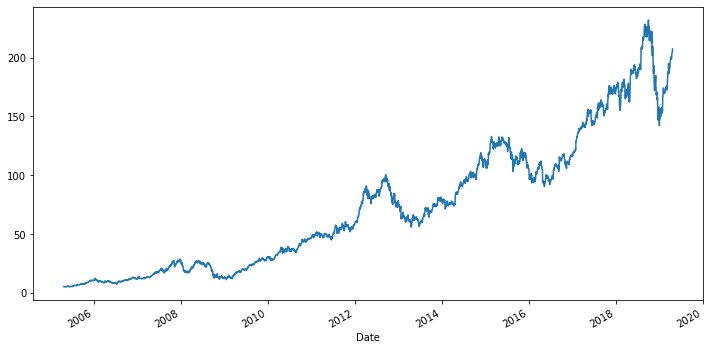

In [13]:
# Plot Close column
prices['Close'].plot(figsize=(12, 6));

In [14]:
# Convert prices to be percent changes from prior row
prices = prices.pct_change()
prices.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,NaN,NaN,NaN,NaN,NaN
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587


In [15]:
# Drop nulls
prices.dropna(inplace=True)

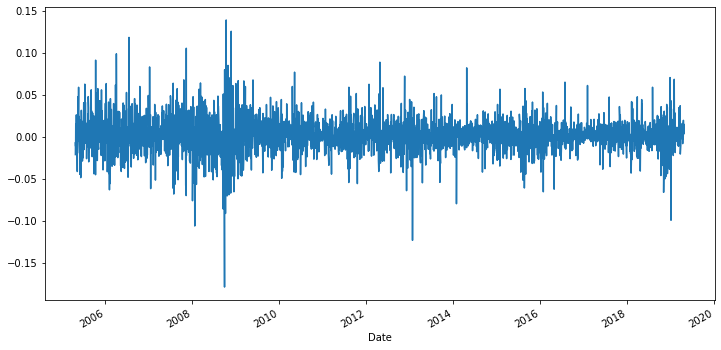

In [17]:
# Plot Close column again
prices['Close'].plot(figsize=(12,6));

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [19]:
# Create Target column
prices['Target'] = (prices['Close'] >= 0).astype(int)
prices.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1


## Merge Prices with SEC filings
---

SEC filings tend to have a huge impact on stock prices. Because of this, we'll want to merge the prices and filings `DataFrames` together.

<details><summary>What kind of join should we use here?</summary>

We'll want to do a left join, so that we don't lose any rows that aren't associated with any SEC filings.
</details>

In [21]:
# Merge DataFrames
df = pd.merge(prices, filings, how = 'left', left_index=True, right_index=True)
df.head()

,Open,High,Low,Close,Volume,Target,10-K,10-Q,8-K
Date,,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0,NaN,NaN,NaN
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0,NaN,NaN,NaN
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0,NaN,NaN,NaN
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1,NaN,NaN,NaN
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1,NaN,NaN,NaN


## Fill `NaN`s
---

After the merge, we now have a bunch of `NaN`s for rows that didn't have any SEC filings on that date. Let's fill those in with 0.

In [22]:
# Fill Nans with 0
df.fillna(0, inplace=True)
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Target    0
10-K      0
10-Q      0
8-K       0
dtype: int64

## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

<details><summary>What do we need to do in train_test_split?</summary>

- set `shuffle=False` so that the order is maintained
</details>

In [23]:
# Create X and y
X = df.drop(columns = 'Target')
y = df[['Target']].values

In [24]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False, random_state=42)

## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [26]:
y.shape

(3522, 1)

In [27]:
# Scale
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [29]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size = 64)

In [31]:
batch_x, batch_y = train_sequences[0]

In [33]:
batch_x.shape # 64 = batch size, 3 = rows, 8= Columns

(64, 3, 8)

In [34]:
batch_y.shape

(64, 1)

In [35]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=128)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 1 `Dense` output layer

We're doing a binary classification problem.

<details><summary>What should our output layer look like?</summary>

- 1 neuron
- sigmoid activation function
- this way, our model predicts a probability
</details>

In [36]:
input_shape = batch_x.shape[1:]
input_shape

(3, 8)

In [37]:
# Design RNN
model = Sequential()

model.add(GRU(8, input_shape=input_shape, return_sequences=True)) #true when next layer is RNN
model.add(GRU(8, return_sequences= False)) #false when next layer is Dense
model.add(Dense(4, activation = 'relu'))
model.add(Dense(4, activation = 'relu')) #Experimental architechure
model.add(Dense(1, activation = 'sigmoid'))

# compile model

model.compile(loss='bce', optimizer=Adam(learning_rate = 0.0005), metrics=['acc'])

In [38]:
# fit model
history = model.fit(train_sequences, validation_data=test_sequences, epochs=50)

Epoch 1/50
42/42 [==============================] - 6s 27ms/step - loss: 0.6933 - acc: 0.5220 - val_loss: 0.6927 - val_acc: 0.5239
Epoch 2/50
42/42 [==============================] - 0s 5ms/step - loss: 0.6927 - acc: 0.5250 - val_loss: 0.6923 - val_acc: 0.5353
Epoch 3/50
42/42 [==============================] - 0s 6ms/step - loss: 0.6922 - acc: 0.5273 - val_loss: 0.6914 - val_acc: 0.5410
Epoch 4/50
42/42 [==============================] - 0s 5ms/step - loss: 0.6917 - acc: 0.5288 - val_loss: 0.6912 - val_acc: 0.5387
Epoch 5/50
42/42 [==============================] - 0s 5ms/step - loss: 0.6914 - acc: 0.5284 - val_loss: 0.6911 - val_acc: 0.5399
Epoch 6/50
42/42 [==============================] - 0s 5ms/step - loss: 0.6910 - acc: 0.5281 - val_loss: 0.6911 - val_acc: 0.5399
Epoch 7/50
42/42 [==============================] - 0s 5ms/step - loss: 0.6908 - acc: 0.5288 - val_loss: 0.6909 - val_acc: 0.5387
Epoch 8/50
42/42 [==============================] - 0s 6ms/step - loss: 0.6906 - acc: 0.5

In [39]:
model.evaluate(test_sequences)

7/7 [==============================] - 0s 3ms/step - loss: 0.6936 - acc: 0.5342


[0.6935747861862183, 0.534168541431427]

In [40]:
y.mean()

0.5283929585462805

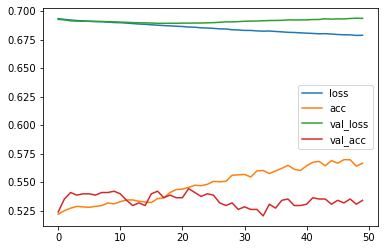

In [41]:
pd.DataFrame(history.history).plot();

## Your turn!
---

Can you improve this model? Try to build a model that minimizes the testing loss even more!

In [43]:
model_1 = Sequential()
model_1.add(GRU(8, input_shape=input_shape, return_sequences=True))
model_1.add(GRU(8, return_sequences= True))
model_1.add(GRU(8, return_sequences= True))
model_1.add(Dense(4, activation = 'relu'))
model_1.add(Dense(4, activation = 'relu'))
model_1.add(Dense(1, activation = 'sigmoid'))
model_1.compile(loss='bce', optimizer=Adam(learning_rate = 0.0005), metrics=['acc'])

In [44]:
history_1 = model_1.fit(train_sequences, validation_data=test_sequences, epochs=10)

Epoch 1/10
42/42 [==============================] - 8s 39ms/step - loss: 0.6930 - acc: 0.5172 - val_loss: 0.6927 - val_acc: 0.5364
Epoch 2/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6925 - acc: 0.5262 - val_loss: 0.6920 - val_acc: 0.5364
Epoch 3/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6922 - acc: 0.5262 - val_loss: 0.6916 - val_acc: 0.5364
Epoch 4/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6920 - acc: 0.5262 - val_loss: 0.6916 - val_acc: 0.5364
Epoch 5/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6920 - acc: 0.5262 - val_loss: 0.6915 - val_acc: 0.5364
Epoch 6/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6920 - acc: 0.5262 - val_loss: 0.6914 - val_acc: 0.5364
Epoch 7/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6919 - acc: 0.5262 - val_loss: 0.6914 - val_acc: 0.5364
Epoch 8/10
42/42 [==============================] - 0s 7ms/step - loss: 0.6919 - acc: 0.5

In [45]:
model_1.evaluate(test_sequences)

7/7 [==============================] - 0s 3ms/step - loss: 0.6913 - acc: 0.5364


[0.691308319568634, 0.5364464521408081]

In [46]:
y.mean()

0.5283929585462805

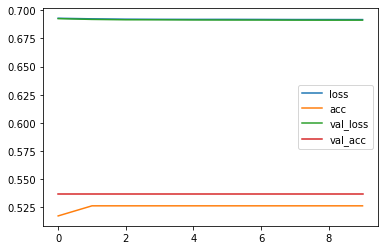

In [47]:
pd.DataFrame(history_1.history).plot();